In [1]:
import numpy as np 
import pandas as pd
import sklearn
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

# grid search k value for SMOTE oversampling for imbalanced classification
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [2]:
maindf=pd.read_csv("../input/amazon-ml-engineer-hiring-challenge/train.csv")
maindf[0:3]

,customer_id,customer_visit_score,customer_product_search_score,customer_ctr_score,customer_stay_score,customer_frequency_score,customer_product_variation_score,customer_order_score,customer_affinity_score,customer_active_segment,X1,customer_category
0,csid_1,13.168425,9.447662,-0.070203,-0.139541,0.436956,4.705761,2.537985,7.959503,C,F,0
1,csid_2,17.092979,7.329056,0.153298,-0.102726,0.380340,4.205138,4.193444,17.517381,C,A,0
2,csid_3,17.505334,5.143676,0.106709,0.262834,0.417648,4.479070,3.878971,12.595155,C,BA,0


In [3]:
print(maindf.info())
print(maindf.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10738 entries, 0 to 10737
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   customer_id                       10738 non-null  object 
 1   customer_visit_score              10738 non-null  float64
 2   customer_product_search_score     10696 non-null  float64
 3   customer_ctr_score                10738 non-null  float64
 4   customer_stay_score               10701 non-null  float64
 5   customer_frequency_score          10738 non-null  float64
 6   customer_product_variation_score  10692 non-null  float64
 7   customer_order_score              10672 non-null  float64
 8   customer_affinity_score           10738 non-null  float64
 9   customer_active_segment           10715 non-null  object 
 10  X1                                10701 non-null  object 
 11  customer_category                 10738 non-null  int64  
dtypes: f

customer segment and X1 are categorical variables. and our target variable is a binary response ( 0 and 1)

In [4]:
if round( (sum(maindf.isnull().sum())/len(maindf) )*100,3) <= 5: # 5% is our threshold 
    print(round( (sum(maindf.isnull().sum())/len(maindf) )*100,3),"%. Remove the NaN data")
    
else:
    print("Preprocessing required")

2.337 %. Remove the NaN data


In [5]:
maindf=maindf.dropna()
maindf.pop("customer_id")

0            csid_1
1            csid_2
2            csid_3
3            csid_4
4            csid_5
            ...    
10733    csid_10734
10734    csid_10735
10735    csid_10736
10736    csid_10737
10737    csid_10738
Name: customer_id, Length: 10491, dtype: object

In [6]:
print(maindf["customer_active_segment"].value_counts())
print("\n")
print(maindf["X1"].value_counts())
print("\n")
print(maindf["customer_category"].value_counts())

# no.of.'0'/ no.of.'0'+ no.of.'1' %
print("% for 0",round ( ( maindf["customer_category"].value_counts()[0] /( maindf["customer_category"].value_counts()[0]+maindf["customer_category"].value_counts()[1]))*100,3))
print("% for 1",round ( (maindf["customer_category"].value_counts()[1] /( maindf["customer_category"].value_counts()[0]+maindf["customer_category"].value_counts()[1]))*100,3))

C     4815
B     4350
D      522
AA     402
A      402
Name: customer_active_segment, dtype: int64


BA    4427
A     2215
F     2200
AA    1574
E       75
Name: X1, dtype: int64


0    9222
1    1269
Name: customer_category, dtype: int64
% for 0 87.904
% for 1 12.096


# the response variable is imbalanced.

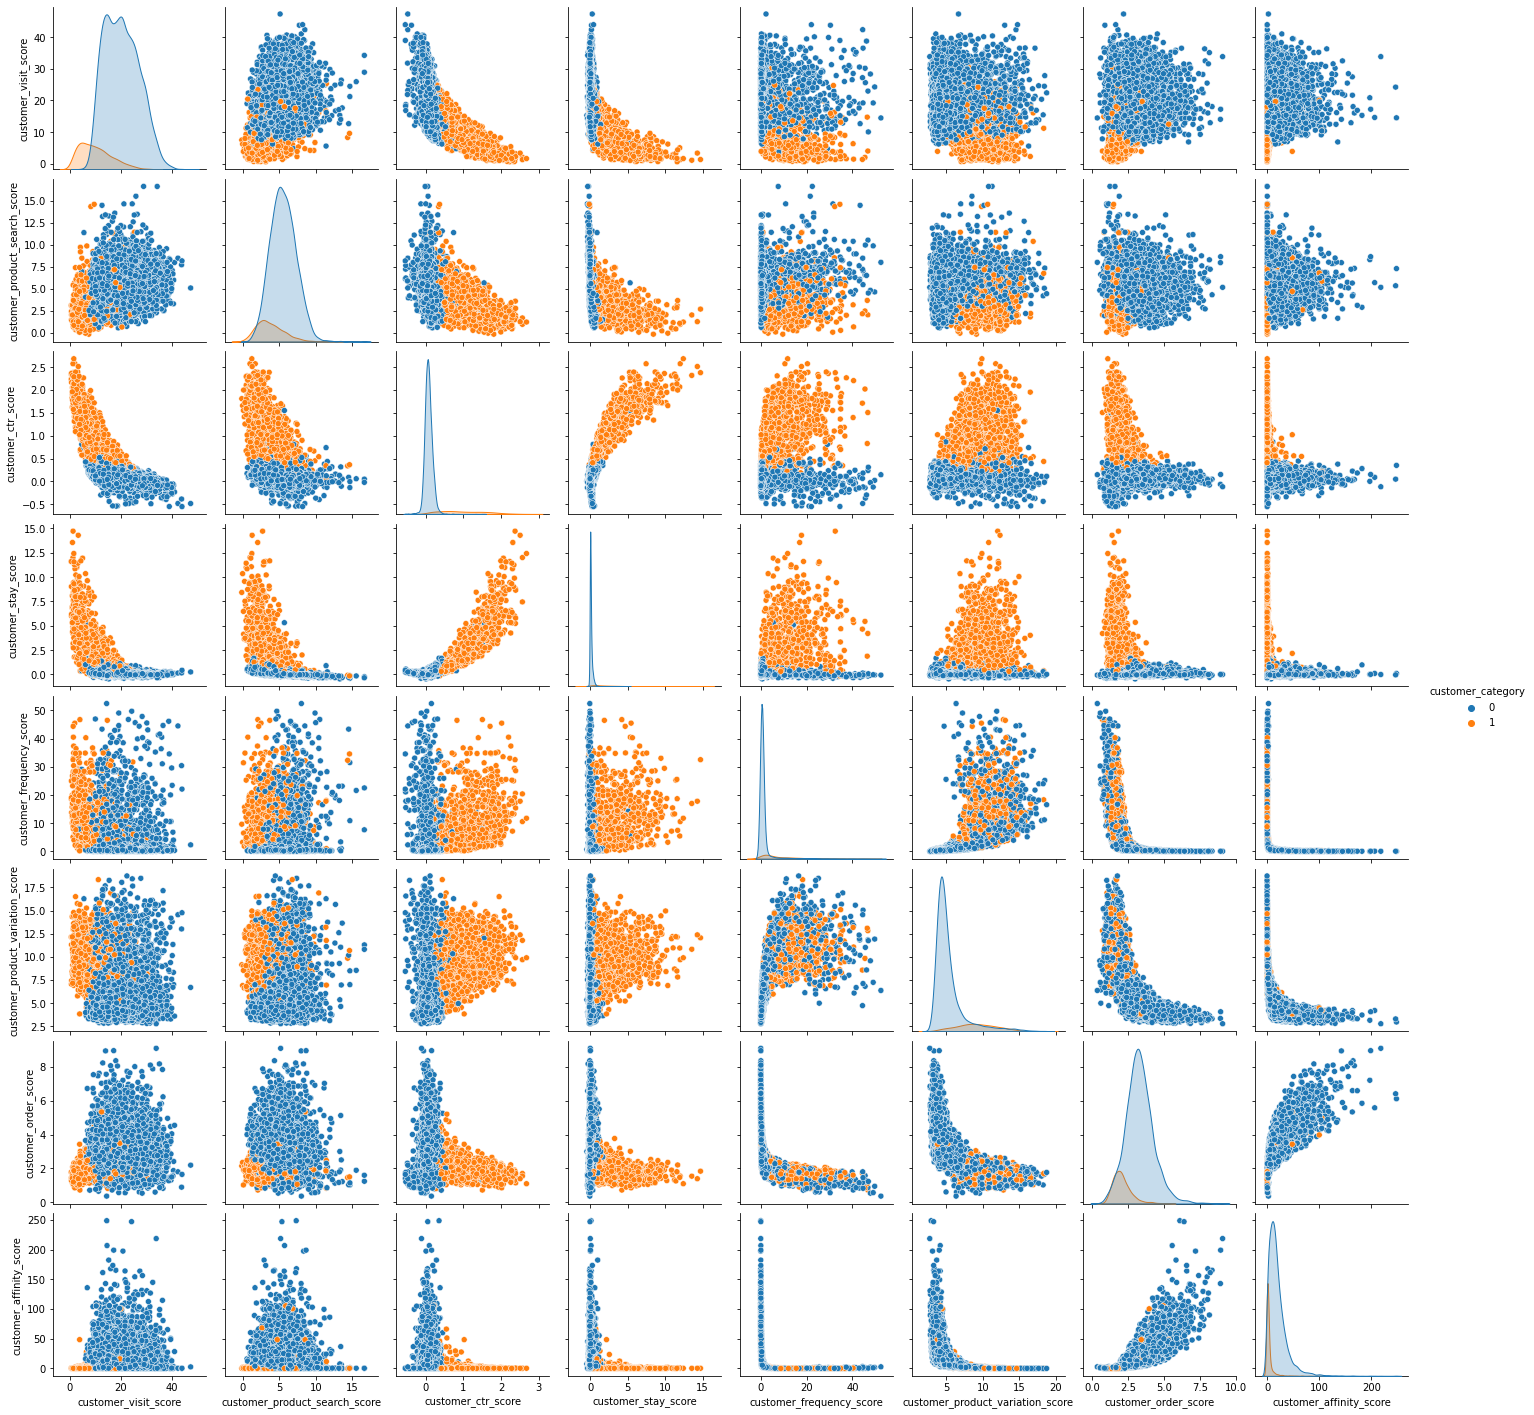

In [7]:
sns.pairplot(data=maindf,hue='customer_category')
# skips 'X1' and 'customer_active_segment'


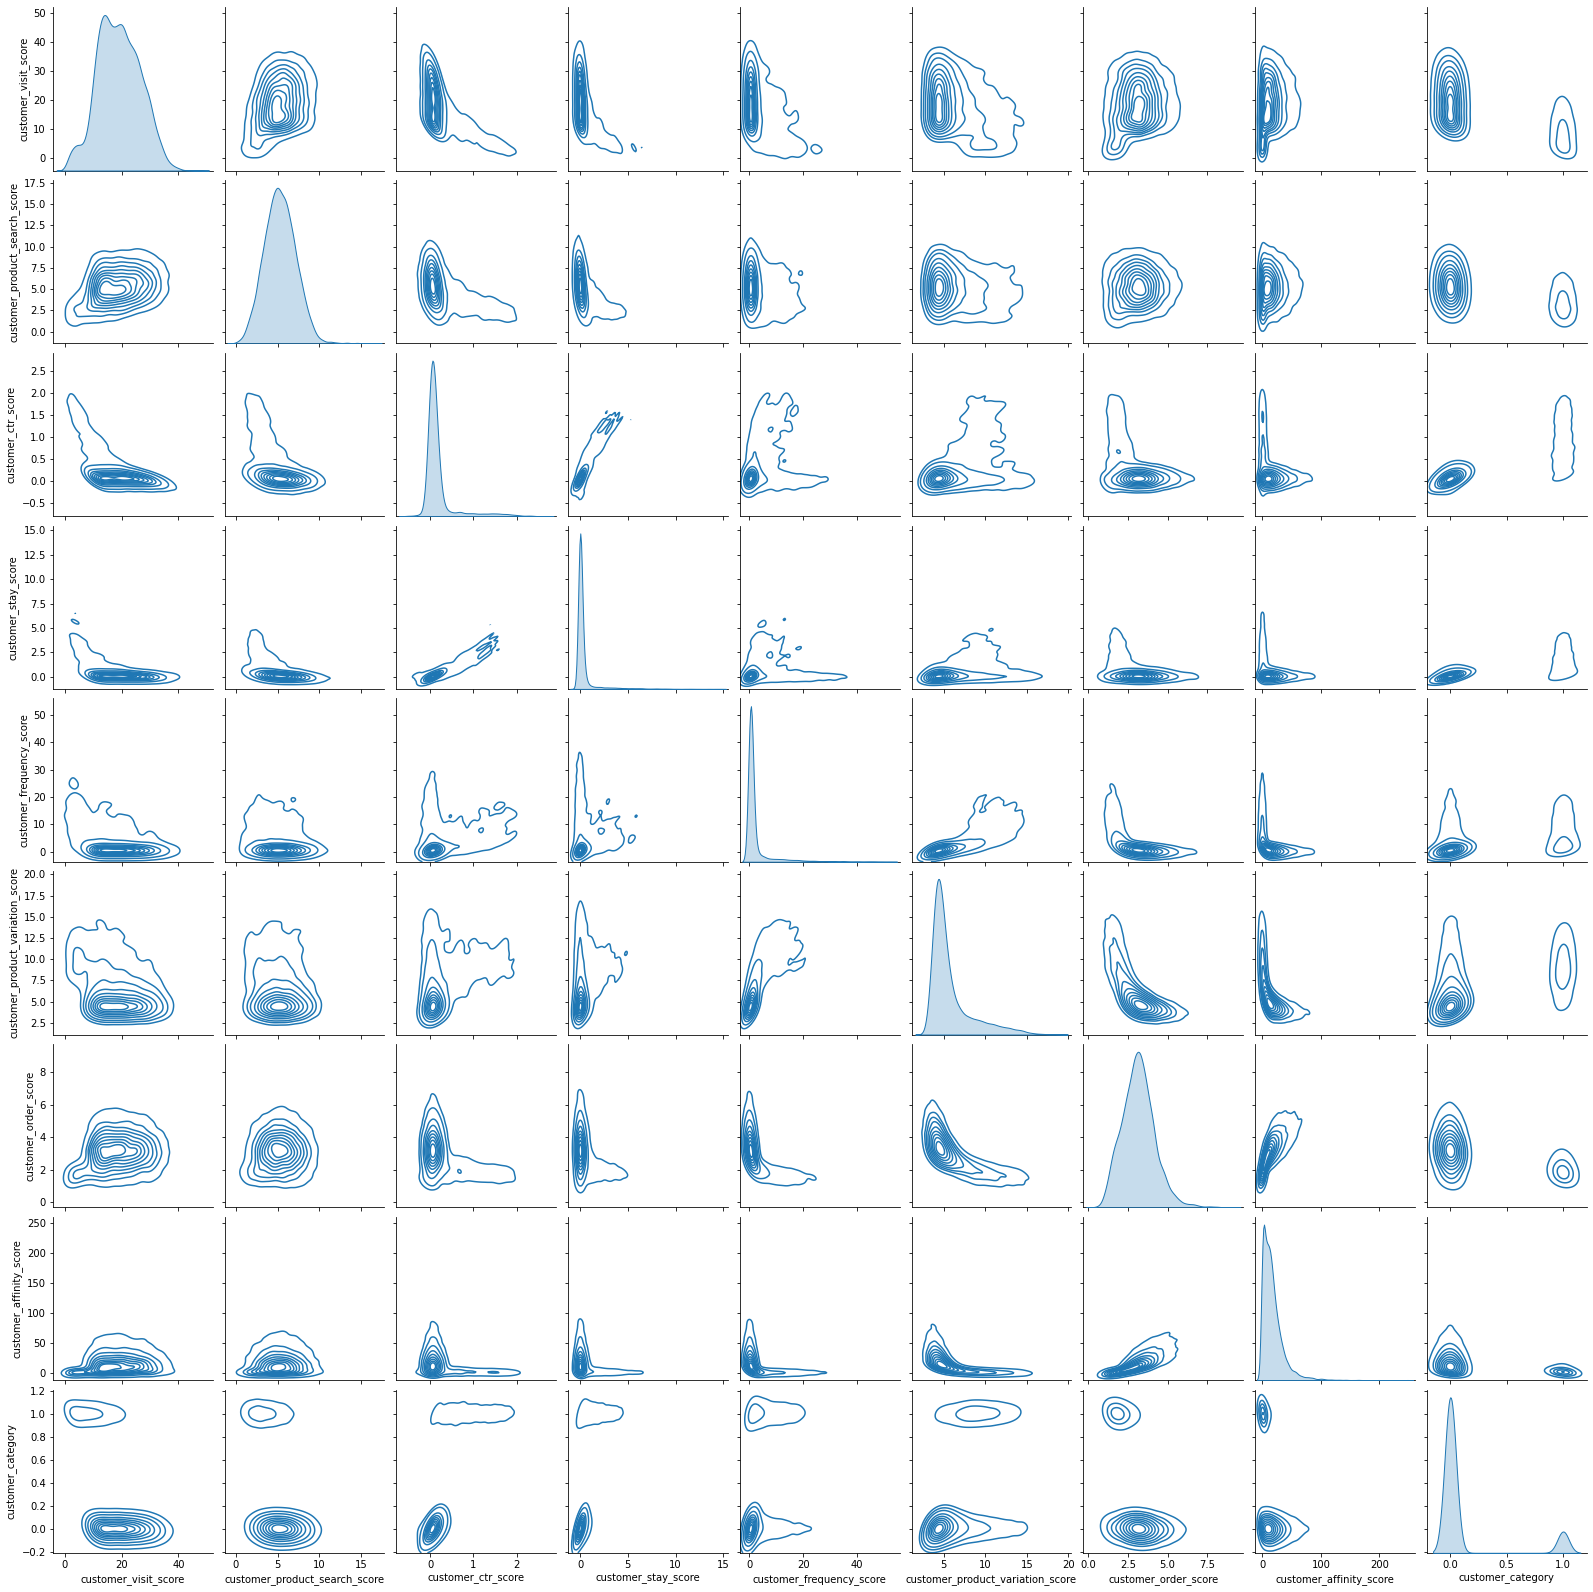

In [8]:
sns.pairplot(data=maindf, kind="kde")

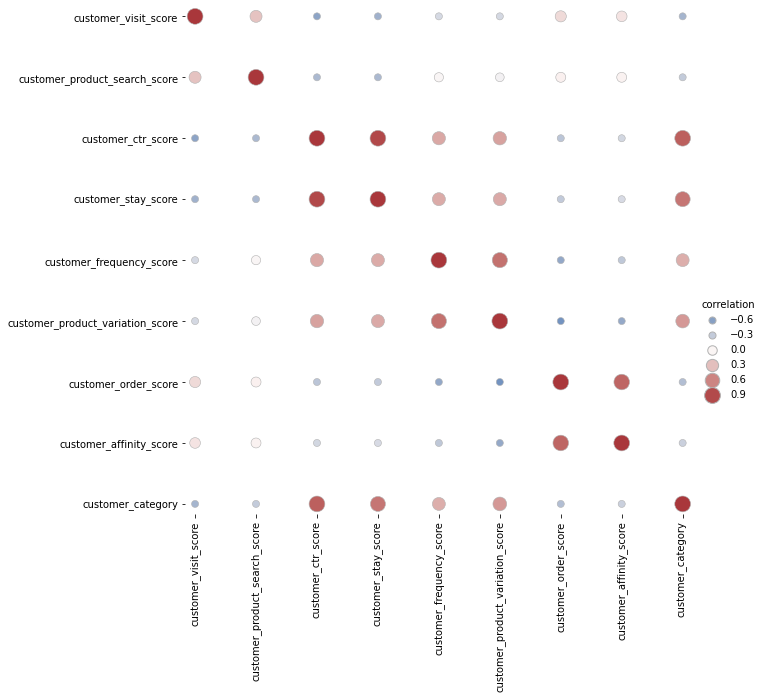

In [9]:
corr_mat = maindf.corr().stack().reset_index(name="correlation")

# Draw each cell as a scatter point with varying size and color
g = sns.relplot(
    data=corr_mat,
    x="level_0", y="level_1", hue="correlation", size="correlation",
    palette="vlag", hue_norm=(-1, 1), edgecolor=".7",
    height=10, sizes=(50, 250), size_norm=(-.2, .8),
)

# Tweak the figure to finalize
g.set(xlabel="", ylabel="", aspect="equal")
g.despine(left=True, bottom=True)
g.ax.margins(.02)
for label in g.ax.get_xticklabels():
    label.set_rotation(90)
for artist in g.legend.legendHandles:
    artist.set_edgecolor(".7")

In [10]:
y=maindf.pop('customer_category')
x=pd.get_dummies(maindf,columns=['customer_active_segment','X1'])

print(x)
print(y)

       customer_visit_score  customer_product_search_score  \
0                 13.168425                       9.447662   
1                 17.092979                       7.329056   
2                 17.505334                       5.143676   
3                 31.423381                       4.917740   
4                 11.909502                       4.237073   
...                     ...                            ...   
10733             23.672615                       6.701514   
10734             25.673028                       6.497796   
10735             31.676844                       7.799880   
10736             28.441780                       5.588302   
10737             20.663035                       4.478301   

       customer_ctr_score  customer_stay_score  customer_frequency_score  \
0               -0.070203            -0.139541                  0.436956   
1                0.153298            -0.102726                  0.380340   
2                0.106709  

In [11]:

#use smoteen
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.combine import SMOTEENN 

print('Original dataset shape %s' % Counter(y))
sme = SMOTEENN(random_state=42)
X_res, y_res = sme.fit_resample(x, y)
print('Resampled dataset shape %s' % Counter(y_res))

Original dataset shape Counter({0: 9222, 1: 1269})
Resampled dataset shape Counter({1: 8873, 0: 7560})


In [12]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.20, random_state=42)

In [13]:
from sklearn.metrics import accuracy_score
clf1=KNeighborsClassifier()
model1=clf1.fit(x_train,y_train)
pred_y=model1.predict(x_test)
print(accuracy_score(y_test,pred_y))



0.9805293580772741


In [14]:
from sklearn.metrics import accuracy_score
clf2=RandomForestClassifier()
model2=clf2.fit(x_train,y_train)
pred_y=model2.predict(x_test)
print(accuracy_score(y_test,pred_y))

0.9838758746577426


In [15]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
clf3=SVC()
model3=clf3.fit(x_train,y_train)
pred_y=model3.predict(x_test)
print(accuracy_score(y_test,pred_y))

0.930635838150289


In [16]:
testdf=pd.read_csv("../input/amazon-ml-engineer-hiring-challenge/test.csv")

In [17]:
testdf=testdf.dropna()
user_test=testdf.pop("customer_id")

In [18]:
test_x=pd.get_dummies(testdf,columns=['customer_active_segment','X1'])

In [19]:
predictions=model2.predict(test_x)
print(predictions)

[0 0 0 ... 0 0 1]


In [20]:
to_submit=pd.DataFrame(list(zip(user_test,predictions)),columns=['userid','customer_category'])